# Project : Predict "college mark"

> # Import Libraries & Read Dataset

In [1]:
import requests

url = 'https://raw.githubusercontent.com/lko9911/Kaggle/master/Compare_Regression_models.py'

r = requests.get(url)

with open('Compare_Regression_models.py', 'w') as f:
    f.write(r.text)

In [2]:
# For Compare modeling
from Compare_Regression_models import evaluate_models

# For Standard data
from sklearn.preprocessing import StandardScaler

# For Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# For Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import r2_score

# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('/kaggle/input/student-attitude-and-behavior/Student Attitude and Behavior.csv')
df.head()

,Certification Course,Gender,Department,Height(CM),Weight(KG),10th Mark,12th Mark,college mark,hobbies,daily studing time,prefer to study in,salary expectation,Do you like your degree?,willingness to pursue a career based on their degree,social medai & video,Travelling Time,Stress Level,Financial Status,part-time job
0,No,Male,BCA,100.0,58.0,79.0,64.0,80.0,Video Games,0 - 30 minute,Morning,40000,No,50%,1.30 - 2 hour,30 - 60 minutes,Bad,Bad,No
1,No,Female,BCA,90.0,40.0,70.0,80.0,70.0,Cinema,30 - 60 minute,Morning,15000,Yes,75%,1 - 1.30 hour,0 - 30 minutes,Bad,Bad,No
2,Yes,Male,BCA,159.0,78.0,71.0,61.0,55.0,Cinema,1 - 2 Hour,Anytime,13000,Yes,50%,More than 2 hour,30 - 60 minutes,Awful,Bad,No
3,Yes,Female,BCA,147.0,20.0,70.0,59.0,58.0,Reading books,1 - 2 Hour,Anytime,1500000,No,50%,1.30 - 2 hour,0 - 30 minutes,Bad,good,No
4,No,Male,BCA,170.0,54.0,40.0,65.0,30.0,Video Games,30 - 60 minute,Morning,50000,Yes,25%,1.30 - 2 hour,30 - 60 minutes,Good,good,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 19 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Certification Course                                    235 non-null    object 
 1   Gender                                                  235 non-null    object 
 2   Department                                              235 non-null    object 
 3   Height(CM)                                              235 non-null    float64
 4   Weight(KG)                                              235 non-null    float64
 5   10th Mark                                               235 non-null    float64
 6   12th Mark                                               235 non-null    float64
 7   college mark                                            235 non-null    float64
 8   hobbies                                 

> # Data Preprocessing

In [5]:
df.isna().sum()

Certification Course                                      0
Gender                                                    0
Department                                                0
Height(CM)                                                0
Weight(KG)                                                0
10th Mark                                                 0
12th Mark                                                 0
college mark                                              0
hobbies                                                   0
daily studing time                                        0
prefer to study in                                        0
salary expectation                                        0
Do you like your degree?                                  0
willingness to pursue a career based on their degree      0
social medai & video                                      0
Travelling Time                                           0
Stress Level                            

In [6]:
object_columns = df.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    unique_count = df[col].nunique()
    print(f'{col} has {unique_count} unique values')

Certification Course has 2 unique values
Gender has 2 unique values
Department has 4 unique values
hobbies has 4 unique values
daily studing time has 6 unique values
prefer to study in has 3 unique values
Do you like your degree? has 2 unique values
willingness to pursue a career based on their degree   has 5 unique values
social medai & video has 6 unique values
Travelling Time  has 7 unique values
Stress Level  has 4 unique values
Financial Status has 4 unique values
part-time job has 2 unique values


In [7]:
for col in object_columns:
    unique_count = df[col].nunique()
    unique_name = df[col].unique()
    if unique_count == 2:
         print(f'{col} has {unique_name}')

Certification Course has ['No' 'Yes']
Gender has ['Male' 'Female']
Do you like your degree? has ['No' 'Yes']
part-time job has ['No' 'Yes']


In [8]:
def Yes_No(value):
    if(value=='Yes'):
        return 1
    elif(value=='No'):
        return 0

def Gender(value):
    if(value=='Male'):
        return 1
    elif(value=='Female'):
        return 0

df['Certification Course'] = df['Certification Course'].apply(Yes_No)
df['Do you like your degree?'] = df['Do you like your degree?'].apply(Yes_No)
df['part-time job'] = df['part-time job'].apply(Yes_No)
df['Gender'] = df['Gender'].apply(Gender)

In [9]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235 entries, 0 to 234
Data columns (total 44 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   Certification Course                                         235 non-null    int64  
 1   Gender                                                       235 non-null    int64  
 2   Height(CM)                                                   235 non-null    float64
 3   Weight(KG)                                                   235 non-null    float64
 4   10th Mark                                                    235 non-null    float64
 5   12th Mark                                                    235 non-null    float64
 6   college mark                                                 235 non-null    float64
 7   salary expectation                                           235 non-null    int

> # Compare models

In [10]:
X = df.drop(['college mark'], axis=1)
y = df['college mark']

evaluate_models(X,y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 33
[LightGBM] [Info] Start training from score 71.078351
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

,Model,RMSE,R2
0,Linear Regression,17.481589,0.053243
1,Ridge Regression,17.388981,0.063247
2,Lasso Regression,15.140450,0.289843
3,ElasticNet,15.593282,0.246728
4,Decision Tree Regressor,22.475473,-0.564928
5,Random Forest Regressor,15.782340,0.228352
6,Support Vector Machine Regressor,17.386236,0.063543
7,K-Nearest Neighbors Regressor,16.581843,0.148191
8,Gradient Boosting Regressor,17.773285,0.021385
9,XGBoost Regressor,16.728473,0.133060


> # Data scaling & Feature engineering

In [11]:
# Extracting highly correlated data
correlation = df.corr()
high_corr_columns = correlation.index[abs(correlation["college mark"]) > 0.1]

# Scaling the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[high_corr_columns])
scaled_data = pd.DataFrame(scaled_data, columns=high_corr_columns)

> # Model : LightGBM Regressor 

In [12]:
y = scaled_data['college mark']
X = scaled_data.drop(columns=['college mark'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_lgbm = LGBMRegressor(learning_rate=0.05, min_data_in_leaf=30, num_leaves=10, reg_alpha=0.5)
best_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 104
[LightGBM] [Info] Number of data points in the train set: 188, number of used features: 10
[LightGBM] [Info] Start training from score 0.026622
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

LGBMRegressor(learning_rate=0.05, min_data_in_leaf=30, num_leaves=10,
              reg_alpha=0.5)

> # Evaluating LightGBM Regressor

In [13]:
predictions = best_lgbm.predict(X_test)

rmse = mean_squared_error(y_test, predictions)**0.5
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("RMSE :", round(rmse,5))
print("MAE :", round(mae,5))
print("R2 :", round(r2,5))

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
RMSE : 0.92418
MAE : 0.57245
R2 : 0.34829


In [14]:
predictions = best_lgbm.predict(X_test)

comparison = pd.DataFrame({'actual': y_test, 'pred': predictions})
comparison.head(10)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


,actual,pred
69,-0.679278,-0.918058
207,-0.679278,-0.716227
180,-0.679278,-0.627897
9,-0.042090,-0.598062
127,0.595099,-0.032241
109,-0.042090,0.066934
196,-1.316466,-0.539788
93,-4.024517,-1.001802
223,0.595099,0.326047
15,-0.679278,-0.573612


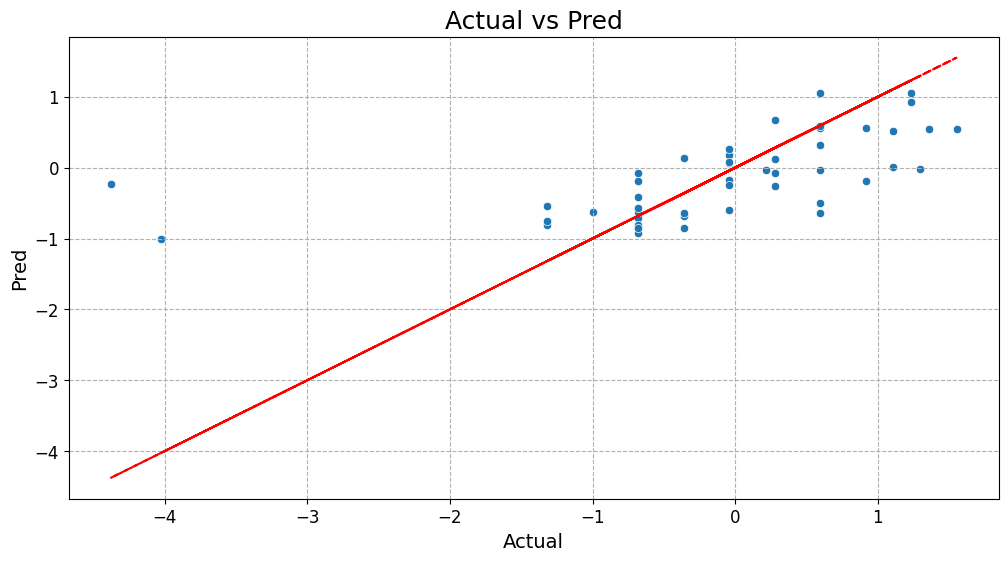

In [15]:
plt.figure(figsize=(12,6))

sns.scatterplot(x='actual', y='pred', data=comparison)
plt.plot(comparison['actual'], comparison['actual'], color='red', linestyle='--')
plt.title('Actual vs Pred', fontsize=18)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Pred', fontsize=14)
plt.xticks(rotation=0, fontsize=12)  
plt.yticks(fontsize=12)
plt.grid(linestyle='--')
plt.show()

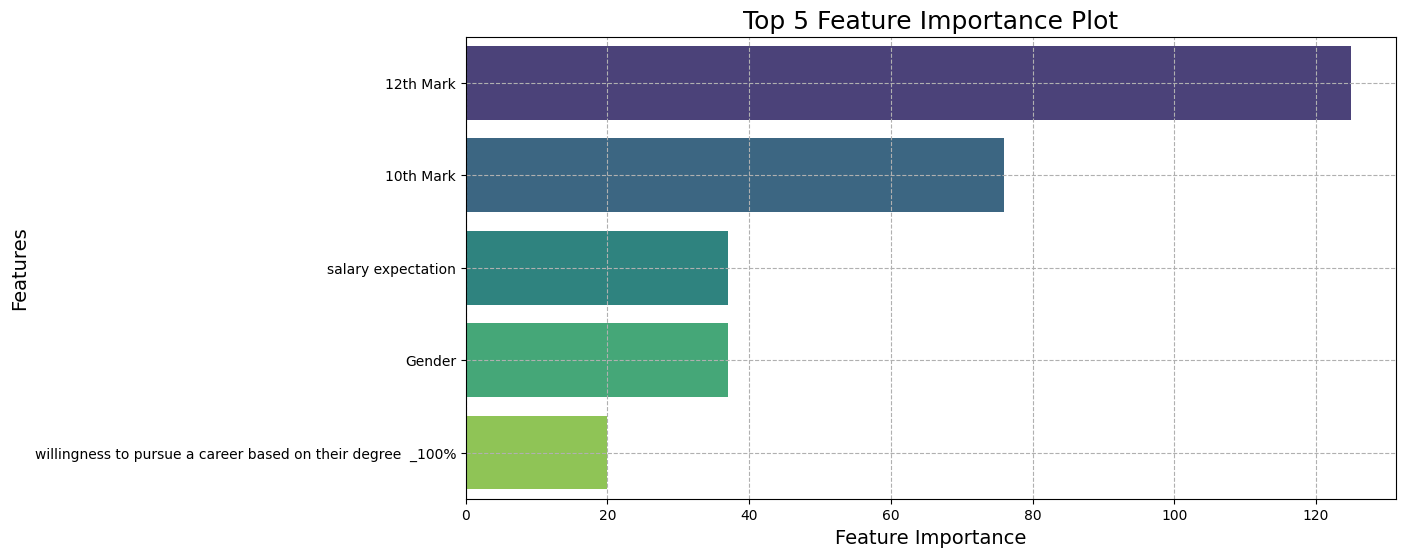

In [16]:
feature_importances = best_lgbm.feature_importances_
sorted_indices = feature_importances.argsort()[::-1][:5]


sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = X_train.columns[sorted_indices]

plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_feature_importances, y=sorted_feature_names, orient='h', palette='viridis')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top 5 Feature Importance Plot', fontsize=18)
plt.grid(linestyle='--')
plt.show()

# Thank